This notebook provides an example of analyzing a focus sequence on a particular target.  It can perform either spectral focusing or stellar PSF focusing, depending on whether a grating is detected in the header or not. 
Written: 02/19/2020 by Sasha Brownsberger 

In [42]:
#Imports needed specifically for focusing
import matplotlib.pyplot as plt 
import time 
import numpy as np 
import math 
import scipy.optimize as optimize
import time 
%matplotlib inline 

In [43]:
os.environ["LSST_DDS_DOMAIN"] = 'lsatmcs'
os.environ["OSPL_URI"] = "file:///home/sashabrownsberger/ospl.xml"

Define the container that will hold the minimum fits

In [44]:
best_fits = {} 

User MUST specify the date_str below.  They can also optionally change: 

(1) The spectrum offsets (distance in rows from star to point in spectrum) 
(2) The size of the box in columns that we slice to do the fitting. 
(3) The binning, in rows
(4) If we are going to apply a bias correction to the data (faster without, no amp offset problems with) 

In [45]:
date_str ="2020-03-12"
spectrum_offsets = [882, 1170, 1467]
spectrum_fit_col_edges = [-100, 100]
binning = 20
apply_bias = 1

[array([[-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4],
       [-4, -3, -2, -1,  0,  1,  2,  3,  4]]), array([[-4, -4, -4, -4, -4, -4, -4, -4, -4],
       [-3, -3, -3, -3, -3, -3, -3, -3, -3],
       [-2, -2, -2, -2, -2, -2, -2, -2, -2],
       [-1, -1, -1, -1, -1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4]])]
smooth_kernel = [[0.06858196 0.08082151 0.09222296 0.10063164 0.10377687 0.10063164
  0.09222296 0.08082151 0.06858196]
 [0.08082151 0.09766888 0.11453212 0.12795437 0.13325214 0.127954

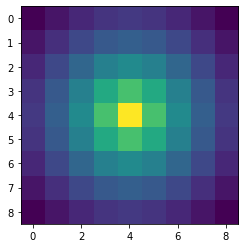

In [46]:
lower_fraction_to_measure_floor = 0.1
seeing_guess_in_arcmin = 1.0
arcmin_to_pixel = 1.0 / 0.1
display_frac = 0.1 
n_free_fit_params = 3
fitting_funct = lambda xs, A, mu, sig, shift: A * np.exp(-(xs - mu) ** 2.0 / (2.0 * sig ** 2.0) ) + shift
bounds=([0.0, -np.inf, 0.01], [np.inf, np.inf, np.inf])
title_font_size  = 18
label_font_size = 14
note_font_size = 12
sleep_time_waiting_for_img = 5 
sub_array_centroiding_box = [[1200, 2800], [1200, 2800]] #np.shape(array) = (4072, 4000)
centroid_std_tolerance = 5.0
n_best_focus_sig_figs = 3

kernel_xs = list(range(-4, 5))
kernel_ys = list(range(-4, 5))
seeing_in_pix = 2.0
kernel_x_mesh, kernel_y_mesh = np.meshgrid(kernel_xs, kernel_ys)
print ([kernel_x_mesh, kernel_y_mesh])
smooth_kernel = 1.0 / np.sqrt(np.pi * seeing_in_pix ** 2.0) * np.exp(- np.sqrt(kernel_x_mesh ** 2.0 + kernel_y_mesh ** 2.0) / (seeing_in_pix) ** 2.0) 
print ('smooth_kernel = ' + str(smooth_kernel))
plt.imshow(smooth_kernel)
plt.show() 

This is a generally useful function for cleanly rounding numbers to a specified number of significant figures. 

In [47]:
def round_to_n (num_to_round, n_sig_figs):
    if num_to_round == 0.0:
        return num_to_round
    rounded_num = round(num_to_round, -int(math.floor(math.log10(abs(num_to_round)))) + (n_sig_figs - 1))
    if int(rounded_num) == rounded_num:
        rounded_num = int(rounded_num)
    return rounded_num

List the names of the images that you would like to display. 

In [80]:
focus_images1 = [int('2020021800' + str(img_num)) for img_num in range(204, 204 + 9)] #Not spectra
focus_images2 = [int('2020021800' + str(img_num)) for img_num in range(220, 220 + 9)] #Not spectra
focus_images3 = [int('2020021800' + str(img_num)) for img_num in range(236, 236 + 9)] 
focus_images4 = [int('2020021800' + str(img_num)) for img_num in range(292, 292 + 9)] 
focus_images5 = [int('2020021800' + str(img_num)) for img_num in range(302, 302 + 9)] 
focus_images6 = [int('2020021800' + str(img_num)) for img_num in range(344, 344 + 9)]  
focus_images7 = [int('2020021800' + str(img_num)) for img_num in range(354, 354 + 9)]  
focus_images8 = [int('2020021800' + str(img_num)) for img_num in range(364, 364 + 9)]  
focus_images9 = [int('2020021900' + str(img_num)) for img_num in range(142, 142 + 9)]
focus_images10 = [int('2020021900' + str(img_num)) for img_num in range(157, 157 + 9)]
focus_images11 = [int('2020021900' + str(img_num)) for img_num in range(166, 166 + 9)]
focus_images12 = [int('2020021900' + str(img_num)) for img_num in range(237, 237 + 9)]
focus_images13 = [int('2020021900' + str(img_num)) for img_num in range(246, 246 + 9)]

#Focus runs on 2020/02/20 
focus_images14 = [int('2020022000' + str(img_num)) for img_num in range(118, 118 + 9)]
focus_positions14 = [-0.1755, -0.1355, -0.0955, -0.0555, -0.0155,  0.0245,  0.0645,  0.1045,  0.1445]

focus_images15 = [int('2020022000' + str(img_num)) for img_num in range(127, 127 + 9)]
focus_positions15 = [-0.36, -0.32, -0.28, -0.24, -0.2,  -0.16, -0.12, -0.08, -0.0]

focus_images16 = [int('2020022000' + str(img_num)) for img_num in range(139, 139 + 9)]
focus_positions16 = [-0.36, -0.32, -0.28, -0.24, -0.2,  -0.16, -0.12, -0.08, -0.0]

focus_images17 = [int('2020022000' + str(img_num)) for img_num in range(150, 150 + 9)]
focus_positions17 = [-0.36, -0.32, -0.28, -0.24, -0.2,  -0.16, -0.12, -0.08, -0.0]

focus_images18 = [int('2020022000' + str(img_num)) for img_num in range(159, 159 + 9)]
focus_positions18 = [-0.36, -0.32, -0.28, -0.24, -0.2,  -0.16, -0.12, -0.08, -0.0]

focus_images19 = [int('2020022000' + str(img_num)) for img_num in range(168, 168 + 9)]
focus_positions19 = [-0.36, -0.32, -0.28, -0.24, -0.2,  -0.16, -0.12, -0.08, -0.0]

focus_images20 = [int('2020022000' + str(img_num)) for img_num in range(189, 189 + 9)] #RG610, ronchi90
focus_positions20 = [-0.36, -0.32, -0.28, -0.24, -0.2,  -0.16, -0.12, -0.08, -0.04]

focus_images21 = [int('2020022000' + str(img_num)) for img_num in range(201, 201 + 9)] #BG40, ronchi90
focus_positions21 = [-0.36, -0.32, -0.28, -0.24, -0.2,  -0.16, -0.12, -0.08, -0.04]

focus_images22 = [int('2020022000' + str(img_num)) for img_num in range(212, 212 + 9)] #quadnotch1, ronchi90
focus_positions22 = [-0.36, -0.32, -0.28, -0.24, -0.2,  -0.16, -0.12, -0.08, -0.04] 

focus_images23 = [int('2020022000' + str(img_num)) for img_num in range(223, 223 + 9)] #quadnotch1, ronchi90
focus_positions23 = [-0.36, -0.32, -0.28, -0.24, -0.2,  -0.16, -0.12, -0.08, -0.04] 

focus_images24 = [int('2020022000' + str(img_num)) for img_num in range(264, 264 + 9)] #empty, ronchi90
focus_positions24 = [-0.36, -0.32, -0.28, -0.24, -0.2,  -0.16, -0.12, -0.08, -0.04]  

focus_images25 = [int('2020022000' + str(img_num)) for img_num in range(294, 294 + 9)] #empty, ronchi90
focus_positions25 = [-0.36, -0.32, -0.28, -0.24, -0.2,  -0.16, -0.12, -0.08, -0.04]

focus_images26 = [int('2020022000' + str(img_num)) for img_num in range(359, 359 + 9)] #empty, ronchi90
focus_positions26 = [-0.4,  -0.35, -0.3,  -0.25, -0.2,  -0.15, -0.1 , -0.05,  0. ]  

focus_images27 = [int('2020022000' + str(img_num)) for img_num in range(368, 368 + 9)] #empty, ronchi90
focus_positions27 = [0. ,  0.05, 0.1 , 0.15, 0.2,  0.25, 0.3 , 0.35, 0.4 ]

focus_images28 = [int('2020022000' + str(img_num)) for img_num in range(377, 377 + 7)] #empty, ronchi90
focus_positions28 = [0.04, 0.06, 0.08, 0.1 , 0.12, 0.14 , 0.16]

focus_images29 = [int('2020022000' + str(img_num)) for img_num in range(395, 395 + 7)] #empty, ronchi90
focus_positions29 = [-0.05, -0.01 , 0.03, 0.07 , 0.11,  0.15,  0.19]

focus_images30 = [int('2020022000' + str(img_num)) for img_num in range(409, 409 + 9)] #empty, ronchi90 
focus_positions30 = [-0.15, -0.1 , -0.05,  0.,    0.05 , 0.1 ,  0.15 , 0.2,   0.25]

focus_images31 = [int('2020022000' + str(img_num)) for img_num in range(418, 418 + 7)] #empty, ronchi90 
focus_positions31 =  [-0.27, -0.23, -0.19, -0.15, -0.11, -0.07, -0.03]

focus_images32 = [int('2020022000' + str(img_num)) for img_num in range(426, 426 + 7)] #empty, ronchi90 
focus_positions32 =  [-0.27, -0.23, -0.19, -0.15, -0.11, -0.07, -0.03]

focus_images33 = [int('2020022000' + str(img_num)) for img_num in range(437, 437 + 9)] #empty, ronchi90 
focus_positions33 = [-0.25, -0.2,  -0.15, -0.1,  -0.05,  0.  ,  0.05,  0.1,   0.15]

focus_images34 = [int('2020022000' + str(img_num)) for img_num in range(455, 455 + 7)] #empty, ronchi90 
focus_positions34 = [-0.21, -0.19, -0.17, -0.15, -0.13, -0.11, -0.09 ]

focus_images35 = [int('2020022000' + str(img_num)) for img_num in range(485, 485 + 9)] #empty, ronchi90 
focus_positions35 = [-0.2 , -0.15, -0.1,  -0.05,  0.,    0.05,  0.1,   0.15,  0.2, ]

#Focus runs on 2020/02/21 
focus_images1 = [int('2020022100' + str(img_num)) for img_num in range(431, 431 + 7)]
focus_positions1 = [-0.3,  -0.25, -0.2,  -0.15, -0.1,  -0.05,  0. ]

focus_images2 = [int('2020022100' + str(img_num)) for img_num in range(441, 441 + 9)]
focus_positions2 = [-0.36, -0.32, -0.28 ,-0.24, -0.2,  -0.16, -0.12, -0.08, -0.04]

focus_images3 = [int('2020022100' + str(img_num)) for img_num in range(453, 453 + 9)] 
focus_positions3 = [-0.4,  -0.35, -0.3,  -0.25, -0.2,  -0.15, -0.1,  -0.05,  0.  ]

focus_images4 = [int('2020022100' + str(img_num)) for img_num in range(474, 474 + 9)] 
focus_positions4 = [-0.55, -0.5,  -0.45, -0.4,  -0.35, -0.3,  -0.25, -0.2,  -0.15]

focus_images5 = [int('2020022100' + str(img_num)) for img_num in range(519, 519 + 9)] 
focus_positions5 = [-0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 , -0.05,  0.  ]

focus_images6 = [int('2020022100' + str(img_num)) for img_num in range(53, 537 + 9)] 
focus_positions6 = [-0.4,  -0.35, -0.3 , -0.25, -0.2,  -0.15 ,-0.1 , -0.05,  0.  ]

focus_images7 = [int('2020022100' + str(img_num)) for img_num in range(563, 563 + 9)] 
focus_positions7 = [-0.42, -0.34, -0.26, -0.18, -0.1,  -0.02,  0.06,  0.14,  0.22]

focus_images8 = [int('2020022100' + str(img_num)) for img_num in range(617, 617 + 9)] 
focus_positions8 = [-0.42, -0.34, -0.26, -0.18, -0.1,  -0.02,  0.06,  0.14,  0.22]

focus_images9 = [int('2020022100' + str(img_num)) for img_num in range(650, 650 + 9)] 
focus_positions9 = [-0.26, -0.22, -0.18 ,-0.14, -0.1,  -0.06, -0.02,  0.02,  0.06]

focus_images10 = [int('2020022100' + str(img_num)) for img_num in range(678, 678 + 11)] 
focus_positions10 = [-0.25, -0.22, -0.19, -0.16, -0.13, -0.1,  -0.07, -0.04, -0.01,  0.02,  0.05]

focus_images11 = [int('2020022100' + str(img_num)) for img_num in range(716, 716 + 11)] 
focus_positions11 = [-0.25, -0.22, -0.19, -0.16, -0.13, -0.1,  -0.07, -0.04, -0.01,  0.02,  0.05]

focus_images12 = [int('2020022100' + str(img_num)) for img_num in range(764, 764 + 9)] 
focus_positions12 = [-0.22, -0.19, -0.16, -0.13, -0.1,  -0.07, -0.04, -0.01,  0.02]

#Focus runs on 2020/03/12 
focus_images1 = [int('2020031200' + str(img_num)) for img_num in range(121, 121 + 9)] 
focus_positions1 = [-0.2955, -0.2755 ,-0.2555, -0.2355,-0.2155, -0.1955, -0.1755, -0.1555, -0.1355]
focus_images2 = [int('2020031200' + str(img_num)) for img_num in range(297, 297 + 9)] 
focus_positions2 = [-0.22999999999999998, -0.21, -0.19, -0.16999999999999998, -0.15, -0.13, -0.11, -0.09, -0.06999999999999999]
focus_images3 = [int('2020031200' + str(img_num)) for img_num in range(306, 306 + 9)] 
focus_positions3 = [-0.13999999999999999, -0.13499999999999998, -0.12999999999999998, -0.12499999999999999, -0.12, -0.11499999999999999, -0.10999999999999999, -0.10499999999999998, -0.09999999999999999]
focus_images4 = [int('2020031200' + str(img_num)) for img_num in range(319, 319 + 9)] 
focus_positions4 = [-0.135, -0.13, -0.125, -0.12000000000000001, -0.115, -0.11, -0.10500000000000001, -0.1, -0.095]
focus_images5 = [int('2020031200' + str(img_num)) for img_num in range(342, 342 + 9)] 
focus_positions5 = [-0.28, -0.26, -0.24000000000000002, -0.22000000000000003, -0.2, -0.18, -0.16, -0.14, -0.12000000000000001]

focus_images = focus_images3[:] 
start_id = '2020031200' + '319'
focus_positions = focus_positions3[:]
print ('focus_images = ' + str(focus_images))
print ('focus_positions = ' + str(focus_positions))

focus_images = [2020031200306, 2020031200307, 2020031200308, 2020031200309, 2020031200310, 2020031200311, 2020031200312, 2020031200313, 2020031200314]
focus_positions = [-0.13999999999999999, -0.13499999999999998, -0.12999999999999998, -0.12499999999999999, -0.12, -0.11499999999999999, -0.10999999999999999, -0.10499999999999998, -0.09999999999999999]


In [81]:
#import math 
##Focus units are given in mm 
#focus_center = -0.00
#focus_step = 0.05
#n_steps = 9
#focus_positions = np.linspace(focus_center - focus_step * math.floor(n_steps / 2), focus_center + focus_step * math.ceil(n_steps / 2 - 1), n_steps)
#print ('focus_positions = ' + str(focus_positions))

In [82]:
print ('focus_images = ' +str(focus_images)) 
print ('focus_positions = ' +str(focus_positions)) 

focus_images = [2020031200306, 2020031200307, 2020031200308, 2020031200309, 2020031200310, 2020031200311, 2020031200312, 2020031200313, 2020031200314]
focus_positions = [-0.13999999999999999, -0.13499999999999998, -0.12999999999999998, -0.12499999999999999, -0.12, -0.11499999999999999, -0.10999999999999999, -0.10499999999999998, -0.09999999999999999]


In [83]:
len(focus_images)

9

These are hard-coded parameters for the fitting and plotting that the user might consider changing

In [84]:
#General imports and setups for managing data 
import os
import lsst.daf.persistence as dafPersist
import lsst.afw.image as afwImage


from lsst.ip.isr.isrTask import IsrTask

isrConfig = IsrTask.ConfigClass()
isrConfig.doLinearize = False
isrConfig.doBias = (True if apply_bias else False)
isrConfig.doFlat = False
isrConfig.doDark = False
isrConfig.doFringe = False
isrConfig.doDefect = True
isrConfig.doAddDistortionModel = False
isrConfig.doWrite = False
isrTask = IsrTask(config=isrConfig)

butler = dafPersist.Butler("/project/shared/auxTel")


#Execute this twice, because of silly ipynb bugs 
%matplotlib inline 

/opt/lsst/software/stack/python/miniconda3-4.7.12/envs/lsst-scipipe-984c9f7/lib/python3.7/site-packages/ipykernel/__main__.py:16: FutureWarning: Config field doAddDistortionModel is deprecated: Camera geometry is incorporated when reading the raw files. This option no longer is used, and will be removed after v19.


The second is a focus along the spectrum of a star.  This is a somewhat subtler problem, and we below provide code to fit a guassian along the cross section of a star.  This assumes that the best fit gaussian in each row does in fact belong to the target object.  User should specify a column range to isolate the target star (

This script is run on the loaded data, and should wait until after all objects in the focus run are read out.  

Trying to read in spectrum from dataId 2020031200306


AT_O_20200312_000306: Dark time less than exposure time. Setting dark time to the exposure time.


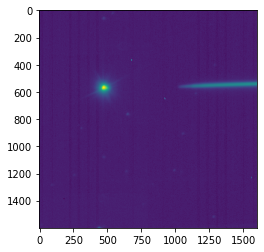

Trying to read in spectrum from dataId 2020031200307


AT_O_20200312_000307: Dark time less than exposure time. Setting dark time to the exposure time.


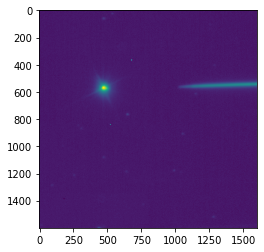

Trying to read in spectrum from dataId 2020031200308


AT_O_20200312_000308: Dark time less than exposure time. Setting dark time to the exposure time.


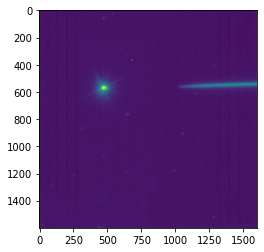

Trying to read in spectrum from dataId 2020031200309


AT_O_20200312_000309: Dark time less than exposure time. Setting dark time to the exposure time.


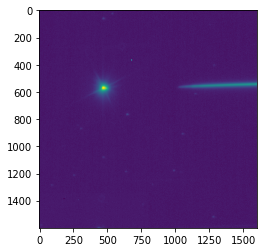

Trying to read in spectrum from dataId 2020031200310


AT_O_20200312_000310: Dark time less than exposure time. Setting dark time to the exposure time.


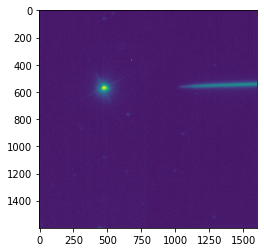

Trying to read in spectrum from dataId 2020031200311


AT_O_20200312_000311: Dark time less than exposure time. Setting dark time to the exposure time.


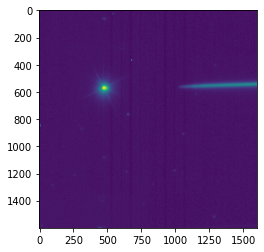

Trying to read in spectrum from dataId 2020031200312


AT_O_20200312_000312: Dark time less than exposure time. Setting dark time to the exposure time.


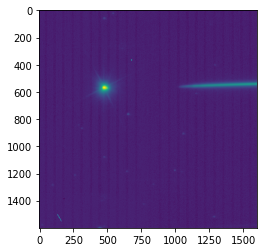

Trying to read in spectrum from dataId 2020031200313


AT_O_20200312_000313: Dark time less than exposure time. Setting dark time to the exposure time.


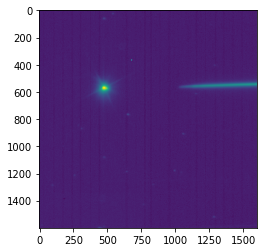

Trying to read in spectrum from dataId 2020031200314


AT_O_20200312_000314: Dark time less than exposure time. Setting dark time to the exposure time.


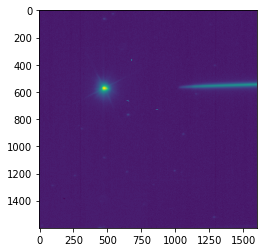

centroid = [1770, 1676]
centroid = [1770, 1676]
centroid = [1770, 1676]
centroid = [1770, 1676]
centroid = [1770, 1676]
centroid = [1770, 1676]
centroid = [1770, 1676]
centroid = [1770, 1676]
centroid = [1770, 1676]


In [86]:
from scipy import ndimage
from matplotlib.colors import LogNorm

all_arrays = [[] for img in focus_images]
all_sub_arrays = [[] for img in focus_images]
image_arrays = [[] for img in focus_images] 
centroids = [[] for img in focus_images]
obj_name = '' #We assume that we are focusing on one and only one object.  Pulled from first image in sequence 
filt = ''
grating =  ''
el_start = '' 
az_start = ''
for i in range(len(focus_images)):
    img = focus_images[i] 
    seq_str = int(str(img)[9:]) #Truncate the leading date string, and lose extra 0s
    dataId = dict(dayObs=date_str)
    dataId["seqNum"] = seq_str
    
    print('Trying to read in spectrum from dataId ' + str(img))
    while False: # butler.datasetExists("raw", seq_str): #I can't find image: 
        time.sleep(sleep_time_waiting_for_img) 
    if apply_bias: 
        try:
            bias
        except NameError:
            bias = butler.get('bias', dataId)
        try:
            defects
        except NameError:
            defects = butler.get('defects', dataId)
        exp = butler.get('raw', dataId)
        exp = isrTask.run(exp, bias = bias, defects=defects).exposure
    else: 
        exp = butler.get('raw', dataId)
        exp = isrTask.run(exp).exposure
        
    focus_position = float(exp.getMetadata().toDict()["FOCUSZ"])
    obj_name = exp.getMetadata().toDict()["OBJECT"]
    filt = exp.getMetadata().toDict()["FILTER"]
    grating = exp.getMetadata().toDict()["GRATING"]
    el_start = float(exp.getMetadata().toDict()["ELSTART"])
    az_start = float(exp.getMetadata().toDict()["AZSTART"]) 
    array = np.transpose(exp.image.array) 
    all_arrays[i] = array.copy() 
    #mask the array to avoid accidentally 
    sub_array = array[sub_array_centroiding_box[0][0]:sub_array_centroiding_box[0][1], sub_array_centroiding_box[1][0]:sub_array_centroiding_box[1][1]]
    smoothed_array =  ndimage.convolve(sub_array, smooth_kernel) 
    plt.imshow(smoothed_array, norm = LogNorm())
    plt.show() 
    centroid = np.unravel_index(np.argmax(smoothed_array), np.shape(smoothed_array)) + np.array([sub_array_centroiding_box[0][0], sub_array_centroiding_box[1][0]])
    #array[sub_array_centroiding_box[0][0]:sub_array_centroiding_box[0][1], sub_array_centroiding_box[1][0]:sub_array_centroiding_box[1][1]] = smoothed_array
    #x_mesh, y_mesh = np.meshgrid(range(0, np.shape(array)[1]), range(0, np.shape(array)[0]))
    #print ('[np.shape(x_mesh), np.shape(y_mesh)] = ' + str([np.shape(x_mesh), np.shape(y_mesh) ]))
    #array[(x_mesh < 500) * (x_mesh > 3500) * (y_mesh < 500) * (y_mesh > 3500)] = 0.0 
    image_arrays[i] = array
    #centroid = task.findMainSource(exp)
    #centroids[i] = localFindCentroid(array) 
    centroids[i] = [int(centroid[0]), int(centroid[1])] 
    
#If one centroid is more than 5sigma off, then set it to the median
centroid_std = [np.std([centroid[0] for centroid in centroids]), np.std([centroid[1] for centroid in centroids])] 
centroid_mean = [np.mean([centroid[0] for centroid in centroids]), np.mean([centroid[1] for centroid in centroids])] 
centroid_median = [int(np.median([centroid[0] for centroid in centroids])), int(np.median([centroid[1] for centroid in centroids]))] 
for i in range(len(centroids)): 
    centroid = centroids[i]
    if (abs(centroid[0] - centroid_mean[0]) / centroid_std[0] < centroid_std_tolerance or abs(centroid[1] - centroid_mean[1]) / centroid_std[1] < centroid_std_tolerance): 
        centroids[i] = centroid_median
        
for i in range(len(focus_images)):
    centroid = centroids[i] 
    print ('centroid = ' + str(centroid))
    #print ([centroid[0] + spectrum_fit_col_edges[0],centroid[0] + spectrum_fit_col_edges[1], centroid[1] + spectrum_offsets[j],centroid[1] + spectrum_offsets[j] + binning])
    array = all_arrays[i] 
    sub_arrays = [array[centroid[0] + spectrum_fit_col_edges[0]:centroid[0] + spectrum_fit_col_edges[1], centroid[1] + spectrum_offsets[j]:centroid[1] + spectrum_offsets[j] + binning] for j in range(len(spectrum_offsets))]
    all_sub_arrays[i] = sub_arrays
    

Do the fits to the seeing

Fitting sub array  0
Fitting sub array  1
Fitting sub array  2
Fitting sub array  3
Fitting sub array  4
Fitting sub array  5
Fitting sub array  6
Fitting sub array  7
Fitting sub array  8


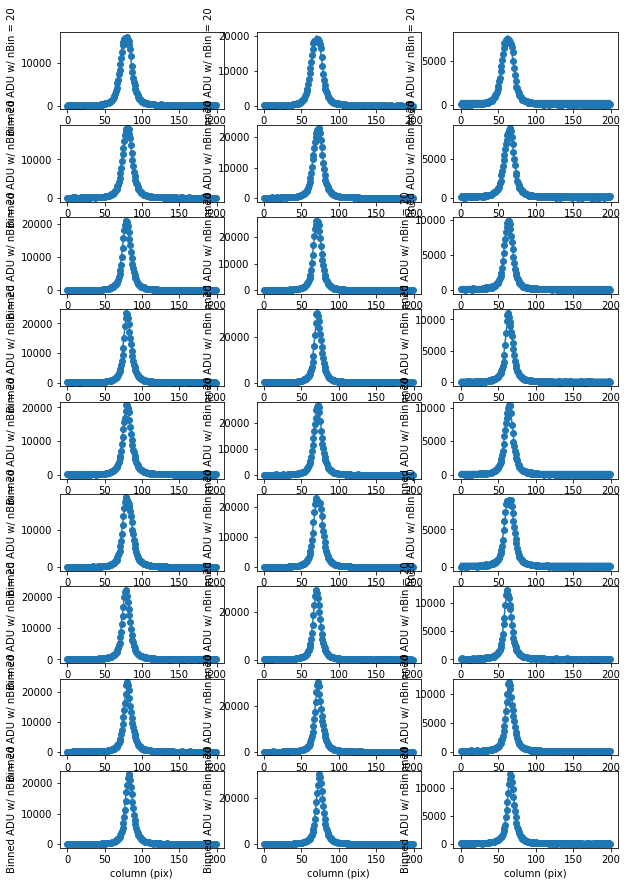

fits = [[[15848.280859109167, 78.42103981894317, 7.308999787357629, 0], [19625.446843305803, 70.1868539460347, 7.266733772294606, 0], [7396.427115837644, 62.329888373609094, 7.322217850708062, 0]], [[17441.092216515022, 80.19413070206829, 6.410574868773332, 0], [22211.939326538093, 71.99064836475357, 6.236596923413322, 0], [8324.673535038517, 64.2770595887684, 6.288184723677202, 0]], [[19876.476337073385, 79.30852900391926, 5.567127575350248, 0], [25434.25512344406, 71.0979196967803, 5.422962878919521, 0], [9287.829023559882, 63.30795791080636, 5.475762215776421, 0]], [[21499.740448479835, 80.1307686354312, 5.0693678233978545, 0], [27804.714187133006, 71.84131252035442, 4.854441705293705, 0], [9915.150966272584, 64.00309619575782, 4.918174712551234, 0]], [[18951.270824090414, 79.91121053325169, 5.784717064508102, 0], [24803.370483994324, 71.7384143860312, 5.460955695500425, 0], [9605.890525050014, 63.97166491810931, 5.43204670394283, 0]], [[17807.728140898438, 80.22768759032215, 6.2867

In [88]:
#Do the fits to the seeing 
fits = [[[] for spectrum_offset in spectrum_offsets] for img in focus_images]

f, axarr = plt.subplots(len(all_sub_arrays), len(spectrum_offsets), figsize = [10,15])
for i in range(len(all_sub_arrays)):
    centroid = centroids[i] 
    sub_arrays = all_sub_arrays[i]
    print ('Fitting sub array  ' + str(i)) 
    for j in range(len(spectrum_offsets)): 
        sub_array = sub_arrays[j]
        row = np.sum(sub_array, axis = 1) 
        xs = range(len(row))
        max_col = np.argmax(row)
        sorted_row = sorted(row)
        floor_estimate = np.mean(sorted_row[0:int(len(sorted_row) * lower_fraction_to_measure_floor)])
        bias_sub_row = np.array(row) - floor_estimate 
        init_guess = [row[max_col], max_col, arcmin_to_pixel * seeing_guess_in_arcmin / np.log(np.sqrt(2.0))]
        try:
            best_fit =  optimize.curve_fit(lambda xs, A, mu, sig: fitting_funct(xs, A, mu, sig, floor_estimate), xs, bias_sub_row, p0=init_guess, maxfev = 10000, bounds = bounds) 
            fit_params = list(best_fit[0]) + [0] 
        except RuntimeError:
            print ('Failed to fit bin ' + str(bin) + '.  Returning initial best guess fit.')
            fit_params = init_guess + [1]
        fits[i][j] = fit_params
        axarr[i,j].scatter(xs, bias_sub_row)
        axarr[i,j].plot(xs, fitting_funct(xs, *fit_params[0:-1], floor_estimate))
        axarr[i,j].set_xlabel('column (pix)')
        axarr[i,j].set_ylabel('Binned ADU w/ nBin = ' + str(binning))
        
plt.show( )
print ('fits = ' + str(fits))

Fits below miss too often.  Only work well when we're symmetric around the minimium.  We should do this fit iteratively, keeping only as many points as are symmetric around the initial guess.  

len(fits) = 9
np.shape(sec_heights) = (3, 9)
sec_widths = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
sec_centers = [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
For 0th offset, fitted minimium = -0.108mm
For 1th offset, fitted minimium = -0.107mm
For 2th offset, fitted minimium = -0.106mm


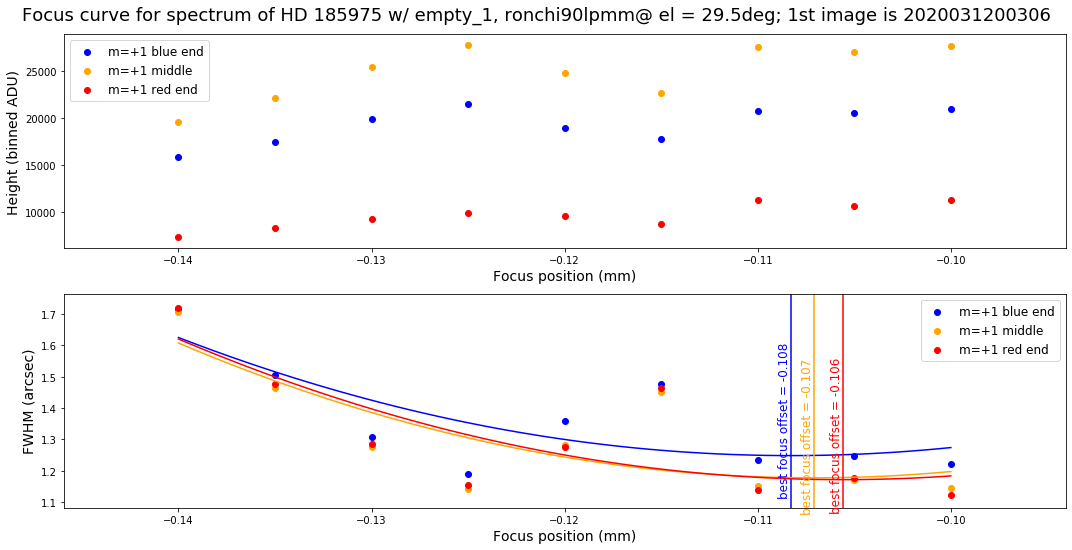

In [89]:
#Now we want to make plots of fit vs focus
#We will plot this
sigma_to_fwhm = 2.35
sec_heights = [[0.0 for pos in focus_positions] for spec_sec in spectrum_offsets]
sec_widths = [[0.0 for pos in focus_positions] for spec_sec in spectrum_offsets]
sec_centers = [[0.0 for pos in focus_positions] for spec_sec in spectrum_offsets]
print ('len(fits) = ' + str(len(fits)))

print ('np.shape(sec_heights) = ' + str(np.shape(sec_heights) ))
print ('sec_widths = ' + str(sec_widths ))
print ('sec_centers = ' + str(sec_centers ))
for fit_num in range(len(fits)):
    single_obj_fit = fits[fit_num]
    for offset_num in range(len(spectrum_offsets)): 
        fit = single_obj_fit[offset_num]
        sec_heights[offset_num][fit_num] = fit[0] 
        sec_widths[offset_num][fit_num] = fit[2] 
        sec_centers[offset_num][fit_num] = fit[1] 


#Now we want to fit the widths of each spectrum section 
fit_mins = [0.0 for offset in spectrum_offsets]
quadratic_fits_of_widths = [[] for offset in spectrum_offsets]
for offset_num in range(len(spectrum_offsets)):
    single_sec_widths = sec_widths[offset_num]
    quadratic_fit = np.polyfit(focus_positions, single_sec_widths, 2)
    quadratic_fits_of_widths[offset_num] = quadratic_fit
    fit_min = -quadratic_fit[1] / (2.0 * quadratic_fit[0])
    print ('For ' + str(offset_num) + 'th offset, fitted minimium = ' + str(round_to_n(fit_min, 3)) + 'mm')
    fit_mins[offset_num] = fit_min
    
best_fits[start_id] = fit_mins[:]  
    
#Now plot the fits and the seeing data points 
f, axarr = plt.subplots(n_free_fit_params-1,1, figsize = [15, 8])
colors = ['b', 'orange', 'r']
xlabels = ['Focus position (mm)', 'Focus position (mm)']
ylabels = ['Height (binned ADU)', 'FWHM (arcsec)']
param_strs = ['Height (binned ADU)', 'Center (col)', 'Sigma width (pix)']
param_legends = ['m=+1 blue end', 'm=+1 middle', 'm=+1 red end']
scats_for_legend = [0.0 for offset in spectrum_offsets]
offsets_to_display = ([1, 2] if filt in ['RG610'] else [0] if filt in ['BG40'] else range(0,  len(spectrum_offsets)) )
for offset_num in offsets_to_display: 
    sec_fwhms = [width * 1.0 / arcmin_to_pixel * sigma_to_fwhm for width in sec_widths[offset_num]]
    display_focus_positions = np.linspace(np.min(focus_positions), np.max(focus_positions), 101)
    scats_for_legend[offset_num] = axarr[0].scatter(focus_positions, sec_heights[offset_num], c = colors[offset_num])
    axarr[0].set_xlabel(xlabels[0], fontsize = label_font_size)
    axarr[0].set_ylabel(ylabels[0], fontsize = label_font_size)
    #axarr[1].scatter(focus_positions, sec_centers[offset_num], c = colors[offset_num])
    axarr[1].scatter(focus_positions, sec_fwhms , c = colors[offset_num])
    axarr[1].plot(display_focus_positions, np.poly1d(quadratic_fits_of_widths[offset_num])(display_focus_positions) * 1.0 / arcmin_to_pixel * sigma_to_fwhm, c = colors[offset_num])
    axarr[1].set_xlabel(xlabels[1], fontsize = label_font_size)
    axarr[1].set_ylabel(ylabels[1], fontsize = label_font_size)
    #axarr[1].arrow(fit_mins[offset_num], min(sec_fwhms), 0.0, max(sec_fwhms) - min(sec_fwhms), color = colors[offset_num])
    axarr[1].axvline(fit_mins[offset_num], color = colors[offset_num])
    axarr[1].text(fit_mins[offset_num], np.mean(sec_fwhms), 'best focus offset = ' + str(round_to_n(fit_mins[offset_num], n_best_focus_sig_figs)), horizontalalignment='right', verticalalignment='center', rotation = 90.0, color = colors[offset_num],  fontsize = note_font_size)
plt.suptitle('Focus curve for spectrum of ' + obj_name + ' w/ ' + filt + ', ' + grating + '@ el = ' + str(round_to_n(el_start, n_best_focus_sig_figs)) + 'deg' + '; 1st image is ' + str(focus_images[0]), fontsize = title_font_size)

axarr[0].legend(scats_for_legend, param_legends, fontsize = note_font_size )
axarr[1].legend(scats_for_legend, param_legends, fontsize = note_font_size )
f.tight_layout(rect=[0, 0.03, 1, 0.95] )
plt.show() 

